In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from invisible_cities.core.core_functions  import shift_to_bin_centers
from invisible_cities.core                 import fit_functions as fitf

In [2]:
def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    create_new_figure(kwargs)

    y, x, p = plt.hist(*args, **kwargs)
    return y, shift_to_bin_centers(x), p


def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    create_new_figure(kwargs)

    z, x, y, p = plt.hist2d(*args, **kwargs)
    return z, shift_to_bin_centers(x), shift_to_bin_centers(y), p

def hist2d_profile(x, y, z, nbinx, nbiny, xrange, yrange, **kwargs):
    """
    Create a profile 2d of the data and plot it as an histogram.
    """
    x, y, z, ze = fitf.profileXY(x, y, z, nbinx, nbiny, xrange, yrange)
    plot_output = display_matrix(x, y, z, **kwargs)
    return ((x, y, z, ze), *plot_output)

def display_matrix(x, y, z, mask=None, **kwargs):
    """
    Display the matrix z using the coordinates x and y as the bin centers.
    """
    nx = x = np.size(x)
    ny = np.size(y)

    dx = (np.max(x) - np.min(x)) / nx
    dy = (np.max(y) - np.min(y)) / ny

    x_binning = np.linspace(np.min(x) - dx, np.max(x) + dx, nx + 1)
    y_binning = np.linspace(np.min(y) - dy, np.max(y) + dy, ny + 1)

    x_ = np.repeat(x, ny)
    y_ = np.tile  (y, nx)
    z_ = z.flatten()

    if mask is None:
        mask = np.ones_like(z_, dtype=bool)
    else:
        mask = mask.flatten()
    h  = hist2d(x_[mask], y_[mask], (x_binning,
                                     y_binning),
                weights = z_[mask],
                **kwargs)
    return h, plt.colorbar()

def create_new_figure(kwargs):
    if kwargs.setdefault("new_figure", True):
        plt.figure()
    del kwargs["new_figure"]

def labels(xlabel, ylabel, title=""):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title ( title)

In [3]:
file_name = "flex.kr83m.1.s3mmp15mm.nexus.h5"
this_dir = "/Users/taylorcontreras/Development/Research/Odyssey_sipmstudy/"

In [4]:
# Get all sensor responses and all the sensor positions
sns_response = pd.read_hdf(this_dir+file_name, 'MC/sns_response')
sns_positions = pd.read_hdf(this_dir+file_name, 'MC/sns_positions')

# Sort to get the sipm positions
sns_pos_sorted = sns_positions.sort_values(by=['sensor_id'])
sipm_positions = sns_pos_sorted[sns_pos_sorted["sensor_name"].str.contains("SiPM")]

# Create separate dataframes for the sipm and pmt response
sns_response_sorted = sns_response.sort_values(by=['sensor_id'])
sipm_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] >999]
pmt_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] < 60]

# Summed pmt energy per event
response_perevent_pmt = pmt_response.groupby('event_id')
summed_charges_byevent_pmt = response_perevent_pmt.agg({"charge":"sum"})

# Summed sipm energy per event
response_perevent_sipm = sipm_response.groupby('event_id')
summed_charges_byevent_sipm = response_perevent_sipm.agg({"charge":"sum"})

# Position of the event(sipm with the max charge)
idx = sipm_response.groupby(['event_id'])['charge'].transform(max) == sipm_response['charge']
max_sipms = sipm_response[idx].sort_values('sensor_id').set_index('sensor_id')
new_max_sipm_positions = sipm_positions.set_index('sensor_id')
this = new_max_sipm_positions.loc[max_sipms.index.values.tolist()] 
event_map = pd.concat([max_sipms.loc[:,'event_id'],this.loc[:,['x','y','z']]], axis=1).set_index('event_id').sort_values(by='event_id')

pmt_map = pd.concat([summed_charges_byevent_pmt,event_map],axis=1)
sipm_map = pd.concat([summed_charges_byevent_sipm,event_map],axis=1)

# Make position a function of r
pmt_r = pmt_map.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1)
pmt_r = pmt_r.to_frame()
pmt_r = pmt_r.rename(columns = {pmt_r.columns[0]:'r'})
pmt_map = pd.concat([pmt_map, pmt_r],axis=1).sort_values(by='r')
sipm_r = sipm_map.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1)
sipm_r = sipm_r.to_frame()
sipm_r = sipm_r.rename(columns = {sipm_r.columns[0]:'r'})
sipm_map = pd.concat([sipm_map, sipm_r],axis=1).sort_values(by='r')

In [5]:
def Center_of_Event(sipm_response_in_event, sipm_positions):
    sensor_ids = sipm_response_in_event.sensor_id
    sensor_positions = sipm_positions.loc[sensor_ids]
    
    denominator = np.sum(sipm_response_in_event.charge)
    numerator = np.sum(sipm_response_in_event.set_index('sensor_id').charge*sensor_positions)

    return numerator/denominator

def Thresh_by_Event(group):
    return group[group.charge > max(group.charge)*.1]

In [6]:
# Set the event position as center of mass
sipm_response_by_event = sipm_response.groupby('event_id')
thresh_sipm_response = sipm_response_by_event.apply(Thresh_by_Event).set_index('event_id').groupby('event_id')
event_x = thresh_sipm_response.apply(lambda row: Center_of_Event(row,sipm_positions.set_index('sensor_id').x))
event_x = pd.DataFrame({'event_id':event_x.index,'x':event_x.values}).set_index('event_id')
event_y = thresh_sipm_response.apply(lambda row: Center_of_Event(row,sipm_positions.set_index('sensor_id').y))
event_y = pd.DataFrame({'event_id':event_y.index,'y':event_y.values}).set_index('event_id')

sipm_charge = sipm_response_by_event.agg({"charge":"sum"}).rename(columns={'charge':'sipm_charge'})
pmt_charge = pmt_response.groupby('event_id').agg({"charge":"sum"}).rename(columns={'charge':'pmt_charge'})
kr_map = pd.concat([pmt_charge,sipm_charge,event_x,event_y],axis=1)
kr_map

,pmt_charge,sipm_charge,x,y
event_id,,,,
100,7420,8194,140.099273,348.676114
101,7387,7945,182.011598,343.189317
102,6780,7280,458.622047,11.437008
103,7346,7887,-0.986590,-404.549808
104,7790,7819,236.646091,-141.352881
105,6319,6998,376.791992,-269.150391
106,6797,7298,449.169708,-61.669708
107,7485,8034,331.664439,-184.732620
108,8043,7885,-94.801020,37.147959


In [7]:
# Testing positions of event as center of mass (energy)
i = 0
for _, grp in sipm_response.groupby('event_id'):
    if i == 10:
        break
    i += 1
    
    print(grp.event_id.tolist()[0])
    #print(Center_of_Event(grp[grp.charge > max(grp.charge)*.1], sipm_positions)) #filter(lambda row: row.charge > max(grp.charge)*.1)
    #sensor_ids = grp.sensor_id
    #sensor_positions = sipm_positions.set_index('sensor_id').loc[sensor_ids]
    #plt.hist2d(sensor_positions.x, sensor_positions.y, weights=grp.set_index('sensor_id').charge, bins=50)
    #plt.show()

100
101
102
103
104
105
106
107
108
109


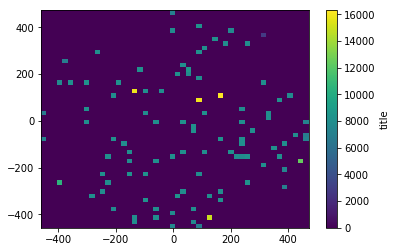

In [8]:
#plt.plot(sipm_map.r, sipm_map.charge)
#plt.plot(pmt_map.r, pmt_map.charge)

plt.hist2d(sipm_map.x, sipm_map.y, weights = sipm_map.charge, bins=[50,50])
plt.colorbar(label='title')

In [9]:
# Need to figure set pmt position to the position of highest sipm in that event


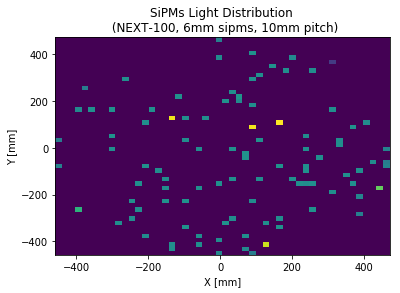

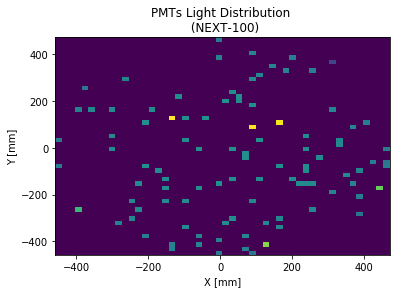

In [10]:
nbins = 500/10
h = hist2d(sipm_map.x, sipm_map.y, (nbins, nbins), weights = sipm_map.charge)
labels("X [mm]", "Y [mm]", "SiPMs Light Distribution \n (NEXT-100, 6mm sipms, 10mm pitch)")

h2 = hist2d(pmt_map.x, pmt_map.y, (nbins, nbins), weights = pmt_map.charge)
labels("X [mm]", "Y [mm]", "PMTs Light Distribution \n (NEXT-100)")